# Lab 6

## Necessary Imports

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [11]:
fips = '100'
name = 'fake_state'

sql_insert = f""" insert into name(fips,name)
                    values('{fips}','{name}')"""
print(sql_insert)

 insert into name(fips,name)
                    values('100','fake_state')


In [3]:
sql = """
     select * from name_income
     where fips = '51'
     """

In [12]:
cur.execute(sql_insert)

In [13]:
conn.commit()

In [14]:
import pandas as pd

va_df = pd.read_sql(sql, con=conn)
va_df.head() #show the top 5 rows

,fips,name,income,year
0,51,Virginia,54240,2005
1,51,Virginia,56277,2006
2,51,Virginia,59562,2007
3,51,Virginia,61233,2008
4,51,Virginia,59330,2009


In [15]:
! pip install jupyter-ai-magics[all] -q

In [16]:
import warnings
warnings.simplefilter('ignore')

In [17]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [18]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


# Question 1
### Code

In [19]:
%%ai gpt4
provide me with a code to visualize the population growth rate for arizona

I'm sorry for the confusion but it's impossible to execute/interpret any programming code using markdown. Markdown is a simple markup language used to format text but it cannot execute code like a programming language such as Python.

What you're asking for seems to be a Python code which can be used to generate a visualization of the population growth rate in Arizona. However, that code cannot be directly run inside Markdown. The output visualization/plot typically cannot be provided in markdown, but can be displayed in Python-supporting notebooks (like Jupyter).

You can certainly include Python code in a markdown file (like README.md) for illustrative purposes, but it will be formatted as static code or text, and won't execute to produce any output or result. 

For actually generating the visualizations, you would need to run the Python code in a Python-supporting environment.

Here's an example of Python code in Markdown file for illustrative purposes:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('arizona_population.csv')

# Calculate growth rate
data['Growth_Rate'] = data['Population'].pct_change()

# Plot growth rate
plt.figure(figsize=(10,5))
plt.plot(data['Year'], data['Growth_Rate'])
plt.title('Arizona Population Growth Rate')
plt.xlabel('Year')
plt.ylabel('Population Growth Rate')
plt.show()
```
Please replace `'arizona_population.csv'` with the name of your data file, and replace `'Year'` and `'Population'` with the accurate column names from your data. Sadly, the mentioned code won't execute/produce visualizations inside a markdown file. It's simply presented for better understanding of the concept.

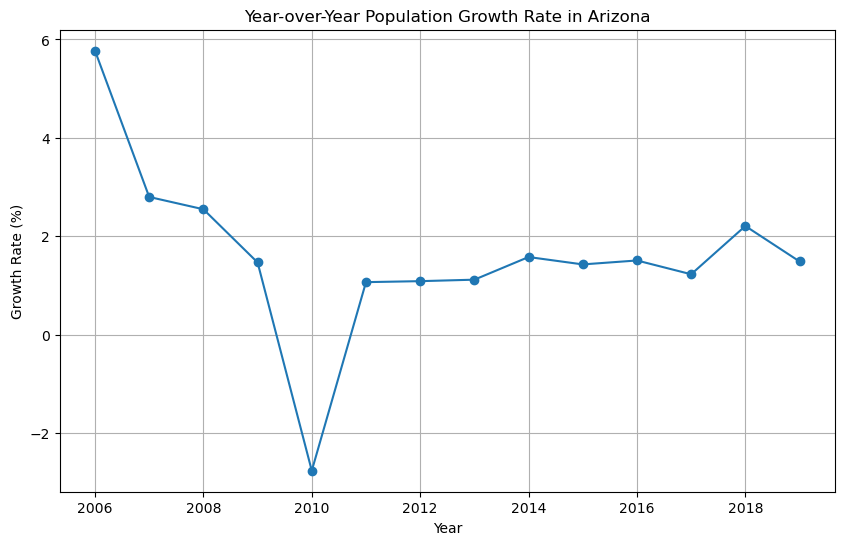

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# Load SQL result into pandas
query_q1 = """
WITH yearly_pop AS (
    SELECT 
        p.year,
        p.pop,
        n.name
    FROM population p
    JOIN name n ON p.fips = n.fips
    WHERE n.name = 'Arizona'
    ORDER BY p.year
)
SELECT 
    year,
    pop,
    LAG(pop) OVER (ORDER BY year) AS prev_pop,
    ROUND(((pop::numeric - LAG(pop) OVER (ORDER BY year)) / LAG(pop) OVER (ORDER BY year)) * 100, 2) AS growth_rate_percent
FROM yearly_pop;
"""
df_pop = pd.read_sql(query_q1, conn)

# Plot growth rate
plt.figure(figsize=(10,6))
plt.plot(df_pop['year'], df_pop['growth_rate_percent'], marker='o', linestyle='-')
plt.title("Year-over-Year Population Growth Rate in Arizona")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True)
plt.show()


### Explanation

The population growth rate in 2006 was at an all-time-high for Arizona, although fell in 2010, then rose and plateaued since 2011. 

# Question 2
### Code

In [23]:
%%ai gpt4
provide me with a code to visualize the relationship of population and income for arizona

Again, while Markdown cannot execute or interpret Python code, it can present static Python code as text or within code blocks for illustrative or documentation purposes. I will provide an example of how you might write Python code that creates a scatter plot visualizing the relationship between population and income of Arizona. You should replace the placeholder names with your actual data file's name and column names:

```python
# Python Code

# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('arizona_data.csv')

# Plot Relationship Between Population and Income
plt.figure(figsize=(10, 5))
plt.scatter(data['Population'], data['Income'])
plt.title('Relationship of Population and Income in Arizona')
plt.xlabel('Population')
plt.ylabel('Income')
plt.show()
```
Remember, this Python code cannot be run directly in a Markdown cell or Markdown file; you need an appropriate Python environment, say Jupyter notebooks, to actually run the code and generate the figure.

The output won't be included in pure markdown output. But when the above python code is executed in a python environment, it will produce a scatter plot indicating the relationship between Population and Income in Arizona.

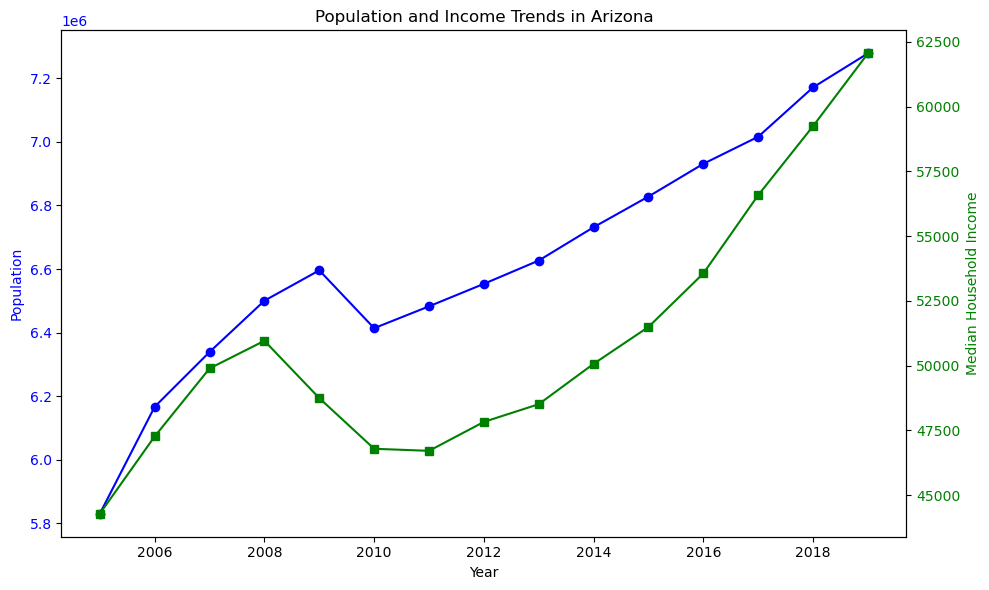

In [24]:
query_q2 = """
SELECT 
    p.year,
    p.pop,
    i.income,
    n.name
FROM population p
JOIN income i ON p.fips = i.fips AND p.year = i.year
JOIN name n ON p.fips = n.fips
WHERE n.name = 'Arizona'
ORDER BY p.year;
"""
df_income_pop = pd.read_sql(query_q2, conn)

# Plot dual-axis chart
fig, ax1 = plt.subplots(figsize=(10,6))

# Population line (left axis)
ax1.set_xlabel("Year")
ax1.set_ylabel("Population", color="blue")
ax1.plot(df_income_pop['year'], df_income_pop['pop'], color="blue", marker='o', label="Population")
ax1.tick_params(axis="y", labelcolor="blue")

# Income line (right axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Median Household Income", color="green")
ax2.plot(df_income_pop['year'], df_income_pop['income'], color="green", marker='s', label="Income")
ax2.tick_params(axis="y", labelcolor="green")

plt.title("Population and Income Trends in Arizona")
fig.tight_layout()
plt.show()

### Explanation
The relationship of population and incomoe in Arizona is directly related. Population and income rose since 2006, dropped in 2010, and has been growing ever since. 

# Question 3
### Code

In [26]:
%%ai gpt4
provide me with a code to visualize the population increases in arizona

Sure, here is a Python code example that visualizes population increase in Arizona when the code is actually run in a Python environment. Remember, Markdown language is not meant for executing code but for documentation. 

Suppose we have a csv file named `"arizona_population.csv"` with columns `"Year"` and `"Population"` .

```python
# Python Code Example

import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('arizona_population.csv')

# Calculate Population Increase
data['Population_Increase'] = data['Population'].diff()

# Now let's plot that
plt.figure(figsize=(10,5))
plt.plot(data['Year'], data['Population_Increase'], label='Population Increase')

plt.xlabel('Year')
plt.ylabel('Population Increase')
plt.title('Arizona Population Increase Over the Years')
plt.legend()
plt.show()
```
Replace `"arizona_population.csv"` and column names `"Year"` and `"Population"` with your actual file name and column names. When executed in a Python environment, the script will load the data, calculate the annual population increase, and plot it. However, this code won't run directly in a Markdown cell or Markdown file. It is essential to run this in a Python environment (such as Jupyter Notebook, Anaconda or similar others).

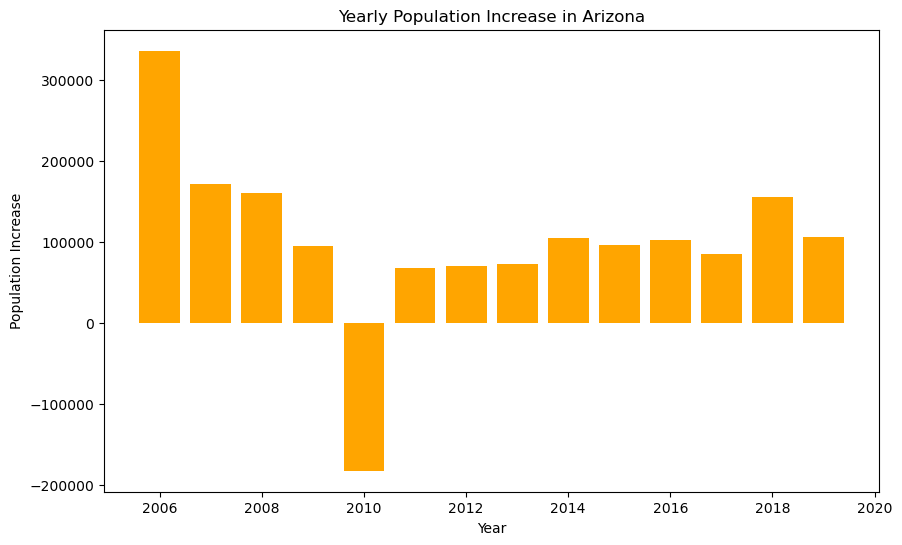

In [27]:
# Load SQL result for all years (to plot trend)
query_q3 = """
WITH yearly_pop AS (
    SELECT 
        p.year,
        p.pop,
        LAG(p.pop) OVER (ORDER BY p.year) AS prev_pop,
        n.name
    FROM population p
    JOIN name n ON p.fips = n.fips
    WHERE n.name = 'Arizona'
)
SELECT 
    year,
    pop,
    (pop - prev_pop) AS pop_increase
FROM yearly_pop
WHERE prev_pop IS NOT NULL
ORDER BY year;
"""
df_pop_increase = pd.read_sql(query_q3, conn)

# Plot population increase
plt.figure(figsize=(10,6))
plt.bar(df_pop_increase['year'], df_pop_increase['pop_increase'], color="orange")
plt.title("Yearly Population Increase in Arizona")
plt.xlabel("Year")
plt.ylabel("Population Increase")
plt.show()


### Explanation

This visualization shows population increases/decreases in arizona since 2006. There was a great increase in 2006, which then greatly decreased in 2010, and has now plataued around 100,000 per year.

# End of Lab